# Set-Up

In [1]:
import os
from PIL import Image, ImageDraw, ImageOps, ImageFont
from tqdm.notebook import trange, tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch import nn
import torch
import yaml
import numpy as np
import cv2
from itertools import groupby
from torchvision.ops import nms
import math


def prep_image_for_detection(image, imgsz=1024):
    coef = min(imgsz / image.shape[0], imgsz / image.shape[1])
    image_ = cv2.resize(image.copy(), dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_CUBIC)
    image_ = cv2.copyMakeBorder(image_, 0, imgsz-image_.shape[0], 0, imgsz-image_.shape[1], cv2.BORDER_CONSTANT, value=(255, 255, 255))

    image_ = torch.FloatTensor(image_) / 255
    image_ = torch.permute(image_, (2, 0, 1)).unsqueeze(0)

    return image_, coef


def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    idxs = np.arange(boxes.shape[0])

    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
        # return only the bounding boxes that were picked using the
        # integer data type
    return boxes[pick].astype("int")


def get_boxes(model, image):
    image_, scale = prep_image_for_detection(image)
    H, W = image.shape[:2]

    output = model(image_)
    output = output.detach().cpu().numpy()[0]

    boxes = list()

    output = output[output[:, 4] > 0.25]

    output[:, 5:] *= output[:, 4:5]

    output[:, 0] = (output[:, 0] - output[:, 2] / 2)  # xc to top left x
    output[:, 1] = (output[:, 1] - output[:, 3] / 2)  # yc to top left y

    output[:, :4] /= scale

    for detection in output:
        x, y, w, h = detection[:4]

        conf = detection[4]
        class_ohe = detection[5:]

        boxes.append([x, y, w, h, conf, np.argmax(class_ohe)])

    boxes = np.array(boxes)
    boxes[(boxes[:, 2] > 0) & (boxes[:, 3] > 0)]
    confs = boxes[:, 4]
    cls = boxes[:, 5]
    boxes = boxes[:, :4]

    nmsstart = time.time()
    boxes = boxes[np.argsort(confs)]

    xyxy_boxes = boxes.copy()
    xyxy_boxes[:, 2] += xyxy_boxes[:, 0]
    xyxy_boxes[:, 3] += xyxy_boxes[:, 1]

    xyxy_boxes = non_max_suppression_fast(xyxy_boxes, 0.25)
    boxes = xyxy_boxes.copy()
    boxes[:, 2] -= boxes[:, 0]
    boxes[:, 3] -= boxes[:, 1]

    # print('nms time:', time.time()-nmsstart)

    boxes = np.maximum(boxes, 0)
    boxes[:, 0] = np.minimum(boxes[:, 0], image.shape[1])
    boxes[:, 1] = np.minimum(boxes[:, 1], image.shape[0])
    boxes[:, 2] = np.minimum(boxes[:, 2], image.shape[1]-boxes[:, 0])
    boxes[:, 3] = np.minimum(boxes[:, 3], image.shape[0]-boxes[:, 1])

    boxes = np.round(boxes[:, :4]).astype(int)
    return boxes, confs, cls


def safe_convert_to_grayscale(image_to_convert):
    if len(image_to_convert.shape) == 2:
        return image_to_convert
    if len(image_to_convert.shape) == 3:
        if image_to_convert.shape[2] == 1:
            return image_to_convert[:, :, 0]
        if image_to_convert.shape[2] == 3:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGR2GRAY)
        if image_to_convert.shape[2] == 4:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGRA2GRAY)

    raise ValueError('invalid shape')


def decode_texts(logits, alphabet, blank_idx):
    if blank_idx < 0:
        blank_idx = len(alphabet)
    best_path_indices = np.argmax(logits, axis=-1)
    best_chars_collapsed = [[alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(e) if idx != blank_idx and idx < len(alphabet)]
                            for e in best_path_indices]
    return [''.join(e) for e in best_chars_collapsed]


def prepare_segment_for_recognition(segment, target_shape=(32, 256)):
    segment = safe_convert_to_grayscale(segment)

    coef = min(target_shape[0] / segment.shape[0], target_shape[1] / segment.shape[1])

    segment = cv2.resize(segment, dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA if coef < 1 else cv2.INTER_CUBIC)
    segment = cv2.copyMakeBorder(segment, 0, target_shape[0]-segment.shape[0], 0, target_shape[1]-segment.shape[1], cv2.BORDER_CONSTANT, value=(255, 255, 255))
    segment = torch.FloatTensor(segment / 255)

    return segment.unsqueeze(0).unsqueeze(0)


def recognize_text(model, image, boxes, alphabets, batch_size=64):
    result = list()
    segments = [image[y: y+h, x: x+w] for (x, y, w, h) in boxes]
    segments = [prepare_segment_for_recognition(segment) for segment in segments]
    segments = torch.cat(segments, axis=0)

    for i in range(1, segments.shape[0] // batch_size + (segments.shape[0] % batch_size != 0) + 1):
        with torch.no_grad():
            y_text, y_script = model(segments[(i-1)*batch_size: i*batch_size])
        rus_indices = np.where(y_script.argmax(-1).numpy() == 0)
        eng_indices = np.where(y_script.argmax(-1).numpy() == 1)

        rus_texts = decode_texts(y_text[rus_indices].cpu().numpy(), alphabets[0], blank_idx=0)
        eng_texts = decode_texts(y_text[eng_indices].cpu().numpy(), alphabets[1], blank_idx=0)

        output = list()
        ridx = 0
        eidx = 0

        for idx in y_script.argmax(-1):
            if idx == 0:
                output.append(rus_texts[ridx])
                ridx += 1
            else:
                output.append(eng_texts[eidx])
                eidx += 1

        result.extend(output)

    return result


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.LeakyReLU(0.1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.MaxPool2d(pool_ksize))

    def forward(self, x):
        return self.block(x)


class ResidualConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ResidualConvBlock2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv2d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)

        e = self.pool(e)

        return self.identity_conv(x) + e


class ResidualConvBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=2):
        super(ResidualConvBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv1d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        e = self.pool(e)

        return self.identity_conv(x) + e


class ScriptClassificationModel(nn.Module):
    def __init__(self, nscripts, input_shape):
        super(ScriptClassificationModel, self).__init__()

        self.feature_extractor = nn.Sequential(nn.Conv1d(input_shape[0], input_shape[0] // 2, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0] // 2),
                                               nn.MaxPool1d(4),

                                               nn.Conv1d(input_shape[0] // 2, input_shape[0] // 4, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0] // 4),
                                               nn.MaxPool1d(4))

        self.feature_extractor = nn.Sequential(ResidualConvBlock1d(input_shape[0], input_shape[0], 2),
                                               ResidualConvBlock1d(input_shape[0], input_shape[0] // 2, 2),
                                               ResidualConvBlock1d(input_shape[0] // 2, input_shape[0] // 2, 2),
                                               ResidualConvBlock1d(input_shape[0] // 2, input_shape[0] // 4, 2),
                                               ResidualConvBlock1d(input_shape[0] // 4, input_shape[0] // 4, 2))

        self.fc = nn.Sequential(nn.Linear(64, nscripts),
                                nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view((x.shape[0], -1))

        x = self.fc(x)

        return x


class RecognitionHead(nn.Module):
    def __init__(self, alphabet_len):
        super(RecognitionHead, self).__init__()

        self.rnn1 = nn.RNN(256, 256, batch_first=True)
        self.rnn2 = nn.RNN(256, 256, batch_first=True)

        self.fc = nn.Sequential(nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, alphabet_len + 1),
                                nn.Softmax(dim=2))

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        x, _ = self.rnn1(x, None)
        x, _ = self.rnn2(x, None)
        x = self.fc(x)

        return x


class MCRNN(nn.Module):
    def __init__(self, alphabet_lens):
        super(MCRNN, self).__init__()

        self.feature_extractor = nn.Sequential(ResidualConvBlock2d(1, 16),
                                               ResidualConvBlock2d(16, 32, (2, 1)),
                                               ResidualConvBlock2d(32, 64),
                                               ResidualConvBlock2d(64, 128),
                                               ResidualConvBlock2d(128, 256, (2, 1)))

        self.script_classifier = ScriptClassificationModel(len(alphabet_lens), (256, 32))

        self.recognition_heads = nn.ModuleList([RecognitionHead(max(alphabet_lens)) for _ in alphabet_lens])

        self.output_dim = max(alphabet_lens) + 1

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(2)

        script_probs = self.script_classifier(x)
        script_indices = script_probs.argmax(-1)

        output = torch.zeros((x.shape[0], x.shape[2], self.output_dim), device=self.device)

        for sidx in torch.unique(script_indices):
            output[script_indices == sidx] = self.recognition_heads[sidx](x[script_indices == sidx])

        return output, script_probs

In [14]:
from Levenshtein import ratio
import numpy as np

def match_boxes(gt_boxes, pred_boxes, iou_thr=0.5):

    matched_boxes_indices = list()
    used_boxes_mask = np.zeros((pred_boxes.shape[0],), dtype=bool)

    for i, (x1, y1, w, h) in enumerate(gt_boxes):
        best_iou = 0
        best_idx = None
        gt_box = x1, y1, w, h
        for j, (x1, y1, w, h) in enumerate(pred_boxes):
            if used_boxes_mask[j]:
                continue
            pred_box = x1, y1, w, h
            iou = calc_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou > iou_thr:
            matched_boxes_indices.append((i, best_idx))
            used_boxes_mask[j] = 1
            
    return matched_boxes_indices

def calc_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    intersection_area = calc_intersection_area(box1, box2)

    return intersection_area / (box1[2] * box1[3] + box2[2] * box2[3] - intersection_area)


def calc_intersection_area(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0] + box1[2], box2[0] + box2[2])
    yB = min(box1[1] + box1[3], box2[1] + box2[3])
    intersection_area = max(0, xB - xA) * max(0, yB - yA)

    return intersection_area


def evaluate_ocr_result(gt_boxes, pred_boxes, gt_words, pred_words, iou_thr=0.5):
    TP = 0
    FP = 0
    FN = 0

    matched_indices = list()
    used_boxes_mask = np.zeros((pred_boxes.shape[0],), dtype=bool)
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_idx = None
        for j, pred_box in enumerate(pred_boxes):
            pred_box = pred_box.ravel()
            gt_box = pred_box.ravel()
            if used_boxes_mask[j]:
                continue   
            iou = calc_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou > iou_thr:
            matched_indices.append((i, best_idx))
            used_boxes_mask[best_idx] = 1
            TP += 1
        else:
            FN += 1

    FP = used_boxes_mask.shape[0] - sum(used_boxes_mask)
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    f1_score = 2*precision*recall/(precision+recall)
    
    lratios = list()
    wers = list()
    
    for i, j in matched_indices:
        lratios.append(ratio(gt_words[i].lower(), pred_words[j].lower()))
        wers.append(gt_words[i].lower() == pred_words[j].lower())

    return sum(lratios) / len(lratios), sum(wers) / len(wers), precision, recall, f1_score


In [4]:

device = torch.device('cpu')

# detection_model_weights = './detection/yolov5/runs/train/yolov5m no slicing 0.6/weights/best.pt'
detection_model_weights = '/home/vshishaev/ocr_engine/docbank_all_0607.pt'
detection_model = torch.hub.load('./yolov5', 'custom', path=detection_model_weights, source='local') 
#print(model(torch.randn(1,3,640,640)))
detection_model.eval()

alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]',
                         'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~"<>[]']

recognition_model_weights = '/home/vshishaev/mcrnn_engine/multilingual_crnn_rst_ce209_0207l.pth'
recognition_model = MCRNN([len(a) for a in alphabets])
recognition_model.load_state_dict(torch.load(recognition_model_weights, map_location=device))
recognition_model.eval();

WARNING ⚠️ torchvision==0.10 is incompatible with torch==2.0.
Run 'pip install torchvision==0.15' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
requirements: Ultralytics requirement ['requests>=2.32.0'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable

requirements: AutoUpdate success ✅ 1.1s, installed 1 package: ['requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v7.0-333-gb9019671 Python-3.9.19 torch-2.0.0.post200 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20877180 parameters, 0 gradients
Adding AutoShape... 


In [20]:

def order_boxes(boxes):
    def contour_dist(box1, box2):
        def axiswise_dist(s1, s2):
            """
            s = (left coord, right coord)
            """
            left = min(s1, s2, key=lambda x: x[0])
            right = max(s1, s2, key=lambda x: x[0])

            return max(0, right[0] - left[1])

        delta_x = axiswise_dist((box1[0], box1[0] + box1[2]), (box2[0], box2[0] + box2[2]))
        delta_y = axiswise_dist((box1[1], box1[1] + box1[3]), (box2[1], box2[1] + box2[3]))

        if delta_x == delta_y == 0:
            return 0
        if min(delta_x, delta_y) == 0 and max(delta_x, delta_y) > 0:
            return max(delta_x, delta_y)
        return math.sqrt(delta_x * delta_x + delta_y * delta_y)

    y_sorted_boxes = np.array(sorted(boxes.copy(), key=lambda x: x[1]), dtype='int64')
    indices = np.array([i for i, box in sorted(enumerate(boxes.copy()), key=lambda x:x[1][1])])

    epsilon = np.mean(boxes[:, 3])

    cluster_labels = np.full((len(y_sorted_boxes, )), fill_value=-1)

    cluster_labels[0] = 0

    for i in range(len(y_sorted_boxes)):
        if cluster_labels[i] == -1:
            cluster_labels[i] = max(cluster_labels) + 1
        for j in range(len(y_sorted_boxes)):
            if contour_dist(y_sorted_boxes[i], y_sorted_boxes[j]) < epsilon:
                min_l = min(cluster_labels[i], cluster_labels[j])
                max_l = max(cluster_labels[i], cluster_labels[j])
                if min_l == -1:
                    cluster_labels[i] = max_l
                    cluster_labels[j] = max_l
                    continue
                cluster_labels[cluster_labels == max_l] = min_l

    cluster_labels = np.array(cluster_labels)

    sorted_boxes = list()
    sorted_indices = list()
    for c in np.unique(cluster_labels):
        cluster_boxes = y_sorted_boxes[cluster_labels == c]
        cluster_indices = indices[cluster_labels == c]
        
        group = [cluster_boxes[0]]
        indices_group = [cluster_indices[0]]
        for i in range(1, len(cluster_boxes)):
            if abs(cluster_boxes[i][1] - cluster_boxes[i - 1][1]) < (epsilon*0.5):
                group.append(cluster_boxes[i])
                indices_group.append(cluster_indices[i])
            else:
                sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
                sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])
                
                group = [cluster_boxes[i]]
                indices_group = [cluster_indices[i]]
                
        sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
        sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])

    sorted_boxes = np.array([np.array(box) for box in sorted_boxes])
    return np.array(sorted_indices), sorted_boxes


def unnormalize_ls_box(result):
  value = result['value']
  orig_w, orig_h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = orig_w * value['x'] / 100.0, orig_h * value['y'] / 100.0
    # x1, y1 = x0 + orig_w * value['width'] / 100.0, y0 + orig_h * value['height'] / 100.0
    w, h = orig_w * value['width'] / 100.0, orig_h * value['height'] / 100.0
    return [x0, y0, w, h]


def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def unnormalize_1000_box(bbox, width, height):
    return [
        int(width * (bbox[0] / 1000)),
        int(height * (bbox[1] / 1000)),
        int(width * (bbox[2] / 1000)),
        int(height * (bbox[3] / 1000)),
    ]


def format_ls_anns(receipt_ann, ds_path, label2id):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  if os.path.exists(os.path.join(ds_path, image_name)):
    pil_im = Image.open(os.path.join(ds_path, image_name))
    pil_im = ImageOps.exif_transpose(pil_im)
    image_np = np.array(pil_im)
    # for sorting purposes :)
    formatted_ex['image_name'] = image_name  
      
    formatted_ex['image'] = image_np

    formatted_ex['boxes'] = np.array([unnormalize_ls_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)
    # sorting boxes and accordingly to them words, ner_tags for better training
    permutation, formatted_ex['boxes'] = order_boxes(formatted_ex['boxes'])
      
    # for i, box in enumerate(formatted_ex['boxes']): # converting boxes to corners x0, y0, x2, y2
    #     x0, y0, w, h = box
    #     formatted_ex['boxes'][i] = np.array([x0, y0, x0+w, y0+h])
      
    formatted_ex['words'] = [ann['value']['text'][0].upper() for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))
    formatted_ex['words'] = np.array([formatted_ex['words'][i] for i in permutation])
      
    formatted_ex['ner_tags'] = [label2id[ann['value']['labels'][0]] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'labels']
    formatted_ex['ner_tags'] = np.squeeze(np.array(formatted_ex['ner_tags']))
    formatted_ex['ner_tags'] = np.array([formatted_ex['ner_tags'][i] for i in permutation])

    assert len(formatted_ex['boxes']) == len(formatted_ex['words']) == len(formatted_ex['ner_tags']) == len(permutation)
      
    return formatted_ex
      
  else:
    # print(image_name)
    return None

def get_third_dim(ds_image):
  return np.dstack((ds_image, ds_image, ds_image))

# removing fourth dimension for some png images
def remove_fourth_dim(ds_image):
  return ds_image[:,:,:3]

In [21]:
from torchmetrics.text import CharErrorRate, WordErrorRate

def calculate_cer_wer(gt_boxes, gt_words, pred_boxes, pred_words, iou_thr=0.4):

    #print(len(gt_boxes), len(gt_words), len(pred_boxes), len(pred_words))
    matched_boxes_indices = match_boxes(gt_boxes, pred_boxes, iou_thr)

    word_refs, word_preds = [], []
    for (i, j) in matched_boxes_indices:
        word_refs.append(gt_words[i].lower())
        word_preds.append(pred_words[j].lower())

    assert len(word_refs) == len(word_preds)
    if len(word_refs) == 0:
        return 0.0, 0.0
    
    # im kinda dumb to calc it by hand
    cer = CharErrorRate()
    cer = cer(word_preds, word_refs)
    wer = WordErrorRate()
    wer = wer(word_preds, word_refs)

    return cer, wer
    

In [22]:
from transformers import LayoutLMv2ForTokenClassification
from transformers import LayoutXLMProcessor

import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

# little hack for passing ssl verification while downloading model from transformers
old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass


with no_ssl_verification():
    processor = LayoutXLMProcessor.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2506", apply_ocr=False)

device = torch.device('cpu')
clf_model = LayoutLMv2ForTokenClassification.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2506")
clf_model.to(device)

labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
    

def pipeline_forward_pass(np_image, processor, clf_model, detec_model, recog_model, device):
        
    width, height = np_image.shape[1], np_image.shape[0]

    # using НАШ ocr
    boxes, _, _ = get_boxes(detec_model, np_image)
    _, boxes = order_boxes(boxes)
    recognition_results = recognize_text(recog_model, np_image, np.array(boxes), alphabets, batch_size=32)
    assert len(boxes) == len(recognition_results)
    
    formatted_results = []

    if len(boxes) > 0:
        for i, box in enumerate(boxes):
            
            x0, y0, x2, y2 = max(0, box[0]), max(0, box[1]), min(box[0]+box[2], width), min(box[1]+box[3], height)

            norm_box = normalize_box_1000([x0, y0, x2, y2], height, width)
            formatted_results.append((norm_box, recognition_results[i]))

        #print(formatted_results)
        words = [res[1] for res in formatted_results]
        boxes = [res[0] for res in formatted_results]

        encoding = processor(np_image, text=words, boxes=boxes, truncation=True,
                             return_offsets_mapping=True, return_tensors="pt",
                             padding="max_length", max_length=512)

        offset_mapping = encoding.pop('offset_mapping')

        for k, v in encoding.items():
            encoding[k] = v.to(device)

        outputs = clf_model(**encoding)

        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        token_boxes = encoding.bbox.squeeze().tolist()

        is_subword = np.array(offset_mapping.squeeze().tolist())[:, 0] != 0

        true_predictions = [pred for idx, pred in enumerate(predictions) if not is_subword[idx]]
        true_boxes = [box for idx, box in enumerate(token_boxes) if not is_subword[idx]]

        return np.array(true_boxes), np.array(true_predictions)

# Dataset Preparation

In [23]:
import json

annotations_path = '/home/vshishaev/layout_all/fixed_receipts_2506.json'
images_path = '/home/vshishaev/layout_all/all_images'

annotations = []

with open(annotations_path, 'r') as ann_f:
    annotations = json.load(ann_f)


labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
clear_dataset = []

for ann in annotations:
    data = format_ls_anns(ann, ds_path='/home/vshishaev/layout_all/val_split', label2id=label2id)
    if data is not None:
        clear_dataset.append(data)

for i, ex in enumerate(clear_dataset):
  if len(ex['image'].shape) == 2:
    clear_dataset[i]['image'] = get_third_dim(clear_dataset[i]['image'])

for i, ex in enumerate(clear_dataset):
  if ex['image'].shape[2] == 4:
    clear_dataset[i]['image'] = remove_fourth_dim(clear_dataset[i]['image'])

# bad image in ../all_images (black square)
# del(clear_dataset[47])

# Calc OCR metrics

  0%|          | 0/31 [00:00<?, ?it/s]

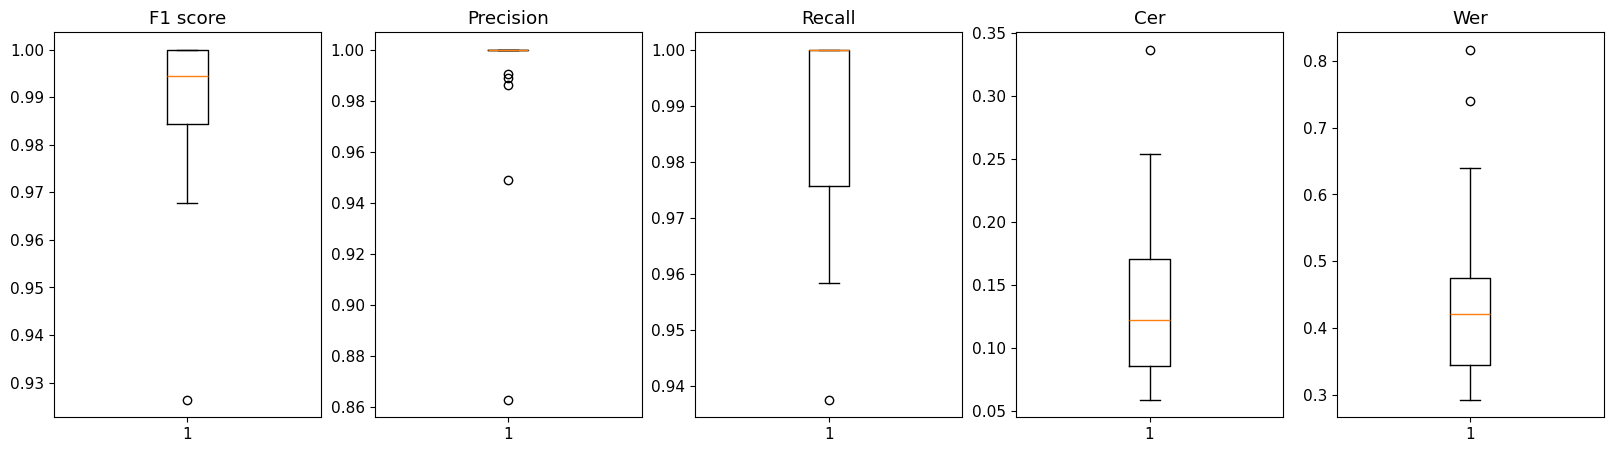

In [24]:
# detector trained with docbank data
%matplotlib inline

lratios = list()
f1s = list()
precisions = list()
recalls = list()
cers = list()
wers = list()
inference_results = []

for i in tqdm(range(len(clear_dataset))):
    
    boxes, confs, cls = get_boxes(detection_model, clear_dataset[i]['image'])
    inference_results.append([i, boxes, confs, cls])
    recognition_results = recognize_text(recognition_model, clear_dataset[i]['image'], np.array(boxes), alphabets, batch_size=32)
    lratio, _, precision, recall, f1_score = evaluate_ocr_result(clear_dataset[i]['boxes'], boxes, clear_dataset[i]['words'], recognition_results, iou_thr=0.5)
    cer, wer = calculate_cer_wer(clear_dataset[i]['boxes'], clear_dataset[i]['words'], boxes, recognition_results)

    lratios.append(lratio)
    f1s.append(f1_score)
    precisions.append(precision)
    recalls.append(recall)
    cers.append(cer)
    wers.append(wer)

fig, axes = plt.subplots(ncols=5, figsize=(20, 5))

#axes[0].boxplot(lratios)
axes[0].boxplot(f1s)
axes[1].boxplot(precisions)
axes[2].boxplot(recalls)
axes[3].boxplot(cers)
axes[4].boxplot(wers)

#axes[0].set_title('mean Levenshtein ratio')
axes[0].set_title('F1 score')
axes[1].set_title('Precision')
axes[2].set_title('Recall')
axes[3].set_title('Cer')
axes[4].set_title('Wer');

In [25]:
# %matplotlib inline

# for result in inference_results[:10]:
#     pil_image = Image.fromarray(clear_dataset[result[0]]['image'])
#     image_draw = ImageDraw.Draw(pil_image)
#     for box in result[1]:
#         image_draw.rectangle([box[0], box[1], box[0]+box[2], box[1]+box[3]], outline='red')

#     plt.figure(figsize=(15,10))
#     plt.imshow(pil_image)

# Calc LayoutXLM Metrics after OCR

In [29]:
# spagetti code

# load receipts validation set
from datasets import load_from_disk

t_valid_dataset = load_from_disk('/home/vshishaev/layout_all/receipts_validation_bef_processor')
t_valid_dataset.set_format('numpy')
# converted_t_valid_images = []

# converting this flatten np.int64 images to reshaped (h, w, 3) np.uint8
# just to check that images in t_valid_dataset and val_images_np are the same
# for i in range(len(t_valid_dataset)):
#     converted_image = np.copy(t_valid_dataset[i]['image']).astype(np.uint8).reshape(t_valid_dataset[i]['image_shape_h_w_d'])
#     converted_t_valid_images.append(converted_image)

# load validation images as np arrays
val_images_np = []
val_receipts_path = '/home/vshishaev/layout_all/val_split'

for image_name in sorted(list(os.listdir(val_receipts_path))):
    image_path = os.path.join(val_receipts_path, image_name)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    val_images_np.append(img)


In [27]:
# forward for all validation examples

preds_labels_ids = []
gt_labels_ids = []

# put model in evaluation mode
clf_model.eval()
with torch.inference_mode():
    for idx, np_image in enumerate(val_images_np):
        
        pred_boxes, pred_labels = pipeline_forward_pass(np_image, processor, clf_model, detection_model, recognition_model, device) 
        gt_boxes, gt_labels = t_valid_dataset[idx]['boxes'].reshape(-1, 4), t_valid_dataset[idx]['ner_tags']

        # gt boxes are normalized [x0, y0, x2, y2] in 0..1000 range, pred boxes after inference have this format too.
        # buuuut, match_boxes uses [x0, y0, w, h] format, has to align it (and optionally unnormalize).
        height, width = np_image.shape[:2]
        gt_box_formatted, pred_box_formatted = [], []
        for i, box in enumerate(gt_boxes):           
            x0, y0, x2, y2 = unnormalize_1000_box(box, width, height)
            gt_box_formatted.append([x0, y0, x2-x0, y2-y0])
            
        for i, box in enumerate(pred_boxes):
            x0, y0, x2, y2 = unnormalize_1000_box(box, width, height)
            pred_box_formatted.append([x0, y0, x2-x0, y2-y0])

        matched_boxes_indices = match_boxes(np.array(gt_box_formatted), np.array(pred_box_formatted), iou_thr=0.4)

        preds_labels_ids.append([])
        gt_labels_ids.append([])
        for i, j in matched_boxes_indices:
            preds_labels_ids[idx].append(pred_labels[j])
            gt_labels_ids[idx].append(gt_labels[i])
            

In [28]:
# better annotations, better detector, better mcrnn, 
# but it's always not enough 

from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds_labels_ids, gt_labels_ids, id2label):

    assert(len(gt_labels_ids) == len(preds_labels_ids))
    
    gt_label_list = [[] for _ in range(len(gt_labels_ids))]
    preds_label_list = [[] for _ in range(len(preds_labels_ids))]

    for i in range(len(preds_labels_ids)):
        for j in range(len(preds_labels_ids[i])):
            gt_label_list[i].append(id2label[gt_labels_ids[i][j]])
            preds_label_list[i].append(id2label[preds_labels_ids[i][j]])
    
    results = {
      "precision": precision_score(gt_label_list, preds_label_list),
      "recall": recall_score(gt_label_list, preds_label_list),
      "f1": f1_score(gt_label_list, preds_label_list),
    }
    return results, classification_report(gt_label_list, preds_label_list)

val_result, class_report = results_test(preds_labels_ids, gt_labels_ids, id2label)
print("Overall results:", val_result)
print(class_report)


Overall results: {'precision': 0.8478260869565217, 'recall': 0.7188940092165899, 'f1': 0.7780548628428927}
              precision    recall  f1-score   support

     ADDRESS       0.67      0.59      0.63        56
     COMPANY       0.74      0.65      0.69        43
        DATE       1.00      0.92      0.96        38
       TOTAL       0.97      0.75      0.85        80

   micro avg       0.85      0.72      0.78       217
   macro avg       0.84      0.73      0.78       217
weighted avg       0.85      0.72      0.78       217

